In [43]:
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import pickle

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [63]:
train = pd.read_csv(r"Dataset/train.csv")
true = train[train['label']==0]
fake = train[train['label']==1]

In [64]:
true["target"] = 0
fake["target"] = 1

true.head()

C:\Users\pinku\AppData\Local\Temp\ipykernel_9776\32679172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true["target"] = 0
C:\Users\pinku\AppData\Local\Temp\ipykernel_9776\32679172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake["target"] = 1


,id,title,author,text,label,Unnamed: 5,Unnamed: 6,target
0,13158,Bernie Sanders Meets President Obama and Pledg...,Alan Rappeport and Julie Hirschfeld Davis,WASHINGTON — Senator Bernie Sanders met wit...,0,NaN,NaN,0
1,13163,Steve Bannon Carries Battles to Another Influe...,Jason Horowitz,ROME — When Stephen K. Bannon was still hea...,0,NaN,NaN,0
2,13164,"Damien Chazelle, ‘La La Land’ Director, on Cal...",John L. Dorman,"Damien Chazelle, the writer and director of th...",0,NaN,NaN,0
3,13166,Jewish Group Praises Trump Administration For ...,Deborah Danan,TEL AVIV — On the eve of Israel’s Holocaust...,0,NaN,NaN,0
4,13172,Southern Poverty Law Center TV Series to Explo...,Jerome Hudson,The Southern Poverty Law Center (SPLC) is deve...,0,NaN,NaN,0


In [65]:
df = pd.concat([true,fake])
df.head()

,id,title,author,text,label,Unnamed: 5,Unnamed: 6,target
0,13158,Bernie Sanders Meets President Obama and Pledg...,Alan Rappeport and Julie Hirschfeld Davis,WASHINGTON — Senator Bernie Sanders met wit...,0,NaN,NaN,0
1,13163,Steve Bannon Carries Battles to Another Influe...,Jason Horowitz,ROME — When Stephen K. Bannon was still hea...,0,NaN,NaN,0
2,13164,"Damien Chazelle, ‘La La Land’ Director, on Cal...",John L. Dorman,"Damien Chazelle, the writer and director of th...",0,NaN,NaN,0
3,13166,Jewish Group Praises Trump Administration For ...,Deborah Danan,TEL AVIV — On the eve of Israel’s Holocaust...,0,NaN,NaN,0
4,13172,Southern Poverty Law Center TV Series to Explo...,Jerome Hudson,The Southern Poverty Law Center (SPLC) is deve...,0,NaN,NaN,0


In [66]:
print(len(true) + len(fake))
print(len(df))

7588
7588


In [67]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,id,title,author,text,label,Unnamed: 5,Unnamed: 6,target
4701,17901,Top US General Pleads With Troops Not To Revol...,Guest Post,"By: The Voice of Reason | In recent weeks, a c...",1,NaN,NaN,1
6663,19872,NaN,Nick Denby,"They are all ""Treasonous"" lying, narcissistica...",1,NaN,NaN,1
150,13336,Vessel For Male Sexual Gratification Very Sad ...,NaN,Man Wearing ‘Jewmerica’ T-Shirt Never Dreamed ...,1,NaN,NaN,1
2730,15925,"The Word From the Trenches – October 27, 2016",Henry Shivley,You can listen on our player . \r\nTo listen o...,1,NaN,NaN,1
4686,17886,NaN,Margaret,by having it be about climate and not about th...,1,NaN,NaN,1


### Preprocessing

In [68]:
def basic_text_cleaning(line_from_column):
    # This function takes in a string, not a list or an array for the arg line_from_column
    
    tokenized_doc = word_tokenize(line_from_column)
    
    new_review = []
    for token in tokenized_doc:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            new_review.append(new_token)
    
    new_term_vector = []
    for word in new_review:
        if not word in stopwords.words('english'):
            new_term_vector.append(word)
    
    final_doc = []
    for word in new_term_vector:
        final_doc.append(wordnet.lemmatize(word))
    
    return ' '.join(final_doc)

def get_dummies(df, col_target):
    df_y = pd.get_dummies(df[col_target])
    df_new = df.join(df_y)
    df_new = df_new.drop(col_target,axis=1)
    return df_new

def prep_features(df, labels, text):
    y = df[labels].values
    comments_train = df[text]
    comments_train = list(comments_train)
    
    return comments_train, y

def prep_tokenizer(texts,MAX_NB_WORDS):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    
    print("Tokeniser created - Saving Tokeniser")
    
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print("Tokeniser saved")
    
def prepare_training_test_data(texts,tokenizer,y):
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Vocabulary size:', len(word_index))
    
    print("Padding sequences")
    
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', data.shape)
    
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = y[indices]
    
    num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
    x_train = data[: -num_validation_samples]
    y_train = labels[: -num_validation_samples]
    x_val = data[-num_validation_samples: ]
    y_val = labels[-num_validation_samples: ]
    
    print('Number of entries in each category:')
    print('training: ', y_train.sum(axis=0))
    print('validation: ', y_val.sum(axis=0))
    
    print('Tokenized sentences: \n', data[0])
    print('One hot label: \n', labels[0])
    
    return x_train, y_train, x_val, y_val

In [69]:
wordnet = WordNetLemmatizer()
regex = re.compile('[%s]' % re.escape(string.punctuation))

In [70]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100   
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [71]:
df = df[["text","target"]]
df.head()

,text,target
4701,"By: The Voice of Reason | In recent weeks, a c...",1
6663,"They are all ""Treasonous"" lying, narcissistica...",1
150,Man Wearing ‘Jewmerica’ T-Shirt Never Dreamed ...,1
2730,You can listen on our player . \r\nTo listen o...,1
4686,by having it be about climate and not about th...,1


In [72]:
text = df
for i in range(0,len(text)):
    text['text'][i] = str(text['text'][i])
    text['text'][i] = re.sub('[^a-zA-Z]', ' ', text['text'][i])
    text['text'][i] = text['text'][i].lower()
df = text

C:\Users\pinku\AppData\Local\Temp\ipykernel_9776\1551148580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['text'][i] = re.sub('[^a-zA-Z]', ' ', text['text'][i])
C:\Users\pinku\AppData\Local\Temp\ipykernel_9776\1551148580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['text'][i] = text['text'][i].lower()
C:\Users\pinku\AppData\Local\Temp\ipykernel_9776\1551148580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t

In [73]:
df.head()

,text,target
4701,by the voice of reason in recent weeks a c...,1
6663,they are all treasonous lying narcissistica...,1
150,man wearing jewmerica t shirt never dreamed ...,1
2730,you can listen on our player to listen on ...,1
4686,by having it be about climate and not about th...,1


In [74]:
from tqdm import tqdm
tqdm.pandas()

df["clean_text"] = df["text"].progress_map(basic_text_cleaning)
df.head()

100%|██████████| 7588/7588 [20:17<00:00,  6.23it/s]


,text,target,clean_text
4701,by the voice of reason in recent weeks a c...,1,voice reason recent week common theme run vast...
6663,they are all treasonous lying narcissistica...,1,treasonous lying narcissistical sociopathic ba...
150,man wearing jewmerica t shirt never dreamed ...,1,man wearing jewmerica shirt never dreamed see ...
2730,you can listen on our player to listen on ...,1,listen player listen smart phone click link ht...
4686,by having it be about climate and not about th...,1,climate general planetary destruction nature l...


In [76]:
df.to_csv("models/clean_news.csv")

In [77]:
df = pd.read_csv(r"models/clean_news.csv")
df["clean_text"]=df["clean_text"].astype(str)

In [78]:
len(df)

7588

In [79]:
df_labels =  pd.get_dummies(df["target"])
len(df_labels)

7588

In [80]:
df_labels = df_labels.reset_index()

In [81]:
df = df.reset_index()

In [82]:
df.head()

,index,Unnamed: 0,text,target,clean_text
0,0,4701,by the voice of reason in recent weeks a c...,1,voice reason recent week common theme run vast...
1,1,6663,they are all treasonous lying narcissistica...,1,treasonous lying narcissistical sociopathic ba...
2,2,150,man wearing jewmerica t shirt never dreamed ...,1,man wearing jewmerica shirt never dreamed see ...
3,3,2730,you can listen on our player to listen on ...,1,listen player listen smart phone click link ht...
4,4,4686,by having it be about climate and not about th...,1,climate general planetary destruction nature l...


In [83]:
df = df.drop("index",axis=1)

In [84]:
df.head()

,Unnamed: 0,text,target,clean_text
0,4701,by the voice of reason in recent weeks a c...,1,voice reason recent week common theme run vast...
1,6663,they are all treasonous lying narcissistica...,1,treasonous lying narcissistical sociopathic ba...
2,150,man wearing jewmerica t shirt never dreamed ...,1,man wearing jewmerica shirt never dreamed see ...
3,2730,you can listen on our player to listen on ...,1,listen player listen smart phone click link ht...
4,4686,by having it be about climate and not about th...,1,climate general planetary destruction nature l...


In [85]:
df_labels =  pd.get_dummies(df["target"])
df_labels = df_labels.reset_index()
df_labels = df_labels.drop("index",axis=1)
df_labels.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [86]:
df_new =df.join(df_labels)

In [87]:
df_new = get_dummies(df=df, col_target="target")
df_new.head()

,Unnamed: 0,text,clean_text,0,1
0,4701,by the voice of reason in recent weeks a c...,voice reason recent week common theme run vast...,0,1
1,6663,they are all treasonous lying narcissistica...,treasonous lying narcissistical sociopathic ba...,0,1
2,150,man wearing jewmerica t shirt never dreamed ...,man wearing jewmerica shirt never dreamed see ...,0,1
3,2730,you can listen on our player to listen on ...,listen player listen smart phone click link ht...,0,1
4,4686,by having it be about climate and not about th...,climate general planetary destruction nature l...,0,1


In [88]:
len(df_new)

7588

In [89]:
labels = [0,1]
x_train, y_train = prep_features(df=df_new, labels=[0,1], text="clean_text")
print(x_train[0])
print(y_train[0])

voice reason recent week common theme run vast majority story covered people make sure preparing possibility major emergency first foremost back may president obama took time extremely busy schedule deliver address fema national response coordination center washington made point stress american preparing disaster emergency evacuation plan given scenario could find big trouble near future following excerpt obama speech come directly official white house website one thing learned course last seven half year government play vital role every citizen responsibility prepared disaster mean taking proactive step like evacuation plan fully stocked disaster supply kit local authority ask evacuate wait biggest reason second one look around surroundings see right perfect storm pure chaos brewing around u ally berlin nuclear missile pointed direction russian attest geopolitical tension sky right german leader along leader czeck republic issued warning people begin stockpiling food emergency supply 

In [90]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [91]:
x_train,y_train,x_test,y_test = prepare_training_test_data(texts=x_train,tokenizer=tokenizer,y=y_train)

Vocabulary size: 208476
Padding sequences
Shape of data tensor: (7588, 200)
Number of entries in each category:
training:  [3018 3053]
validation:  [776 741]
Tokenized sentences: 
 [  685 24017 14251   485   320    70    80    13  1355   124    34    55
   394   300  5630    81    74    11  5381   188   983   485    18  1188
  3851    11  1626   310   268     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

In [95]:
embeddings_index = {}
word_index = tokenizer.word_index
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [96]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [97]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="sigmoid")(x)

In [98]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 100)          20847700  
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [99]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [100]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_test, y_test))

Training progress:
Epoch 1/20
190/190 [==============================] - 16s 18ms/step - loss: 0.5433 - accuracy: 0.7284 - val_loss: 0.4340 - val_accuracy: 0.7904
Epoch 2/20
190/190 [==============================] - 3s 14ms/step - loss: 0.3897 - accuracy: 0.8241 - val_loss: 0.3380 - val_accuracy: 0.8616
Epoch 3/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2968 - accuracy: 0.8799 - val_loss: 0.2958 - val_accuracy: 0.8708
Epoch 4/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2328 - accuracy: 0.9079 - val_loss: 0.2482 - val_accuracy: 0.8958
Epoch 5/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2007 - accuracy: 0.9171 - val_loss: 0.2681 - val_accuracy: 0.8853
Epoch 6/20
190/190 [==============================] - 3s 14ms/step - loss: 0.1710 - accuracy: 0.9310 - val_loss: 0.2515 - val_accuracy: 0.8926
Epoch 7/20
190/190 [==============================] - 3s 14ms/step - loss: 0.1346 - accuracy: 0.9468 - val_loss: 0.2538 - 

In [101]:
model.save("LSTM_model_1.h5")

In [102]:
# serialize model to JSON
model_json = model.to_json()
with open("LSTM_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [103]:
import matplotlib.pyplot as plt

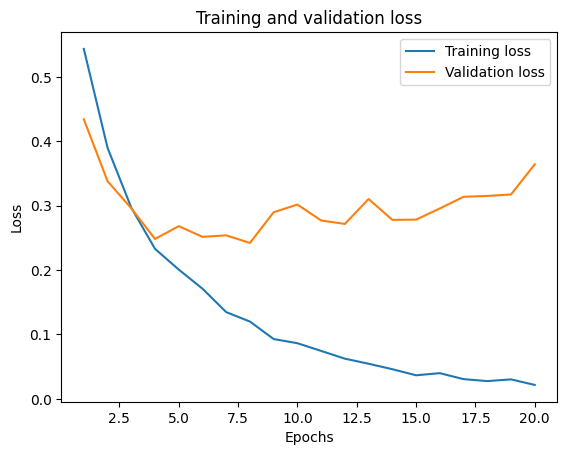

In [104]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [105]:
def predict(model,i):
    clean_text =[]
    i = basic_text_cleaning(i)
    clean_text.append(i)
    sequences = tokenizer.texts_to_sequences(clean_text)
    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
    pred = model.predict(data)
    return pred

In [106]:
test = "Facebook Inc will allow employees participating in the protest to take the time off without drawing down their vacation days, spokesman Andy Stone said. Separately, online therapy company Talkspace said it ended partnership discussions with Facebook. Talkspace CEO Oren Frank tweeted he would “not support a platform that incites violence, racism, and lies.”"

In [107]:
predict(model=model,i=test)[0][0]

NameError: name 'model_new' is not defined

In [ ]:
model.predict(x_test)

array([[4.3928901e-09, 1.0000000e+00],
       [3.9913253e-14, 1.0000000e+00],
       [1.0000000e+00, 6.2545832e-12],
       ...,
       [5.1183279e-15, 1.0000000e+00],
       [9.8688555e-01, 1.6947305e-02],
       [2.2732119e-07, 9.9999976e-01]], dtype=float32)

In [ ]:
x_test[2]

array([ 1765,    17,  2389,  1765,    47,  1120,  2869,    29,    45,
           8,  2317,   386,     9,   490,  8097,   125,   519,  1955,
         935,   115,   129,  8173,  3830,     1,   127,     8,    19,
         734,  1120,   618,   737,    29,    45,   619,     9,  3830,
           1,     8,    57,    29,    45,  3558,  2317,   490,   635,
           5,    81,   500,   179,   737,   471,     9,     8,  5469,
         517, 43082,     5,    81,  2969,  8368,  6292,  5802,   215,
           9,  3830,   316,  1765,  1868,  2176,   877,    30,  7832,
         392,  6292,  5802,  8566,   273,   646,    28,   896,  1002,
        3578,   392,     7,    10,    20,     2,  1066,  3181,   619,
         104,   215,   311,   127,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
y_classes = predict(model=model,i=test).argmax(axis=-1)

In [ ]:
y_classes[0]

0

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model("LSTM_model.h5")